# Importing the Dataset and Processing the Tokens for NN and GloVe Combination

In [1]:
import pandas as pd
import ast

# Replace with your dataset name on Kaggle
train_df = pd.read_csv("/kaggle/input/cse440-cleaned-dataset/train_cleaned.csv")
test_df  = pd.read_csv("/kaggle/input/cse440-cleaned-dataset/test_cleaned.csv")

# Convert tokens from stringified lists back to Python lists
if isinstance(train_df["tokens"].iloc[0], str):
    train_df["tokens"] = train_df["tokens"].apply(ast.literal_eval)
    test_df["tokens"]  = test_df["tokens"].apply(ast.literal_eval)

print(train_df.shape, test_df.shape)
train_df.head()


(279999, 4) (59999, 4)


,QA Text,Class,clean_text,tokens
0,Question Title:\nWhat are the names of the 206...,Science & Mathematics,name <num> bone human body <num> bone human bo...,"[name, <num>, bone, human, body, <num>, bone, ..."
1,Question Title:\ncan you tell me the universit...,Education & Reference,tell university name distance mphil food nutri...,"[tell, university, name, distance, mphil, food..."
2,Question Title:\nSuggestions or Advice on trac...,Politics & Government,suggestion advice tracking someone owes money ...,"[suggestion, advice, tracking, someone, owes, ..."
3,Question Title:\nwhere can i find the system o...,Entertainment & Music,find system poem victim written guitarist band...,"[find, system, poem, victim, written, guitaris..."
4,Question Title:\nwill the first tour match bet...,Sports,first tour match india south africa telecast c...,"[first, tour, match, india, south, africa, tel..."


# Label Encoding Prediction Output Class &
# Organizing Train/Validation/Test using StratifiedShuffleSplit

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_all  = le.fit_transform(train_df["Class"])
y_test = le.transform(test_df["Class"])
num_classes = len(le.classes_)
print("Classes:", list(le.classes_))

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
idx_tr, idx_val = next(sss.split(train_df, y_all))
tr_df  = train_df.iloc[idx_tr].reset_index(drop=True)
val_df = train_df.iloc[idx_val].reset_index(drop=True)
y_tr, y_val = y_all[idx_tr], y_all[idx_val]

print("Train/Val/Test:", tr_df.shape, val_df.shape, test_df.shape)


Classes: ['Business & Finance', 'Computers & Internet', 'Education & Reference', 'Entertainment & Music', 'Family & Relationships', 'Health', 'Politics & Government', 'Science & Mathematics', 'Society & Culture', 'Sports']
Train/Val/Test: (237999, 4) (42000, 4) (59999, 4)


# Padding/Truncating To Make Sequences Equal 

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

tr_texts  = [" ".join(t) for t in tr_df["tokens"]]
val_texts = [" ".join(t) for t in val_df["tokens"]]
test_texts= [" ".join(t) for t in test_df["tokens"]]

tok = Tokenizer(num_words=100_000, oov_token="<OOV>")
tok.fit_on_texts(tr_texts)
vocab_size = min(100_000, len(tok.word_index) + 1)

seq_tr   = tok.texts_to_sequences(tr_texts)
seq_val  = tok.texts_to_sequences(val_texts)
seq_test = tok.texts_to_sequences(test_texts)

lengths = np.array([len(s) for s in seq_tr if s])
maxlen  = int(np.percentile(lengths, 95)) if len(lengths) else 300
maxlen  = max(80, min(maxlen, 400))  # keep between 80–400

Xtr  = pad_sequences(seq_tr,  maxlen=maxlen, padding="post", truncating="post")
Xval = pad_sequences(seq_val, maxlen=maxlen, padding="post", truncating="post")
Xte  = pad_sequences(seq_test, maxlen=maxlen, padding="post", truncating="post")

print("vocab_size:", vocab_size, "| maxlen:", maxlen)


2025-09-06 08:54:47.599576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757148887.846179      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757148887.920772      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


vocab_size: 100000 | maxlen: 140


# Loading the GloVe Embeddings

In [5]:
# Load GloVe embeddings into a dictionary
import numpy as np

embedding_dim = 100  # Define the dimension of the GloVe embeddings (adjust as per your GloVe file)
glove_embeddings = {}

with open('/kaggle/input/glove6b/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector


# Creating the Embeddings Matrix

In [6]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, index in tok.word_index.items():
    if index < vocab_size:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

# Neural Networks Models + GloVe TRAINING & EVALUATION ( 1 x 7 ) = 7 Experiments

------------------------------------------------------------------------------------------------------

# DNN + GloVe

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Embedding, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

# Define the model
dnn_model = Sequential()

# Add the GloVe embedding layer
dnn_model.add(Embedding(input_dim=vocab_size,  # Size of the vocabulary
                    output_dim=embedding_dim,  # Use the embedding_dim variable (100)
                    weights=[embedding_matrix],  # Pre-trained GloVe embeddings
                    input_length=maxlen,  # Length of input sequences
                    trainable=False))     # Freeze the GloVe embeddings during training

# Add GlobalAveragePooling1D to convert 3D output to 2D
# This averages the embeddings across the sequence dimension
dnn_model.add(GlobalAveragePooling1D())

# Add a Dense hidden layer with ReLU activation
dnn_model.add(Dense(128, activation='relu'))

# Add Dropout layer to prevent overfitting
dnn_model.add(Dropout(0.5))

# Add another Dense hidden layer
dnn_model.add(Dense(64, activation='relu'))

# Add another Dropout layer
dnn_model.add(Dropout(0.3))

# Output layer with softmax activation for multi-class classification
dnn_model.add(Dense(num_classes, activation='softmax'))

# Build the model explicitly to see proper output shapes
dnn_model.build(input_shape=(None, maxlen))

# Print the model summary
dnn_model.summary()

# Compile the model
dnn_model.compile(optimizer=Adam(learning_rate=0.002), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1757148939.793042      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757148939.793702      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 140, 100)       │    10,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 100)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,021,834 (38.23 MB)

 Trainable params: 21,834 (85.29 KB)

 Non-trainable params: 10,000,000 (38.15 MB)

In [12]:
dnn_model_history = dnn_model.fit(Xtr, y_tr,
                            validation_data=(Xval, y_val),
                            epochs=10,
                            batch_size=64)

Epoch 1/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6504 - loss: 1.1045 - val_accuracy: 0.6704 - val_loss: 1.0196
Epoch 2/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6517 - loss: 1.1043 - val_accuracy: 0.6696 - val_loss: 1.0205
Epoch 3/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6520 - loss: 1.1002 - val_accuracy: 0.6701 - val_loss: 1.0168
Epoch 4/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6511 - loss: 1.1033 - val_accuracy: 0.6702 - val_loss: 1.0158
Epoch 5/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6526 - loss: 1.0962 - val_accuracy: 0.6703 - val_loss: 1.0155
Epoch 6/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6532 - loss: 1.0966 - val_accuracy: 0.6716 - val_loss: 1.0150
Epoch 7/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6527 - loss: 1.0950 - val_accuracy: 0.6705 - val_loss: 1.0159
Epoch 8/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6535 - loss: 1.0949 - 

In [13]:
# Evaluate model on test set
test_loss, test_accuracy = dnn_model.evaluate(Xte, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6323 - loss: 1.1115
Test Loss: 1.011775016784668
Test Accuracy: 0.6728112101554871


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
                        precision    recall  f1-score   support

    Business & Finance       0.64      0.42      0.51      6000
  Computers & Internet       0.78      0.84      0.81      6000
 Education & Reference       0.52      0.43      0.47      6000
 Entertainment & Music       0.64      0.63      0.64      6000
Family & Relationships       0.63      0.73      0.68      5999
                Health       0.73      0.76      0.74      6000
 Politics & Government       0.68      0.76      0.72      6000
 Science & Mathematics       0.68      0.76      0.72      6000
     Society & Culture       0.57      0.53      0.55      6000
                Sports       0.78      0.87      0.82      6000

              accuracy                           0.67     59999
             macro avg       0.67      0.67      0.67     59999
          weighted avg       0.67      0.67      0.67     59999



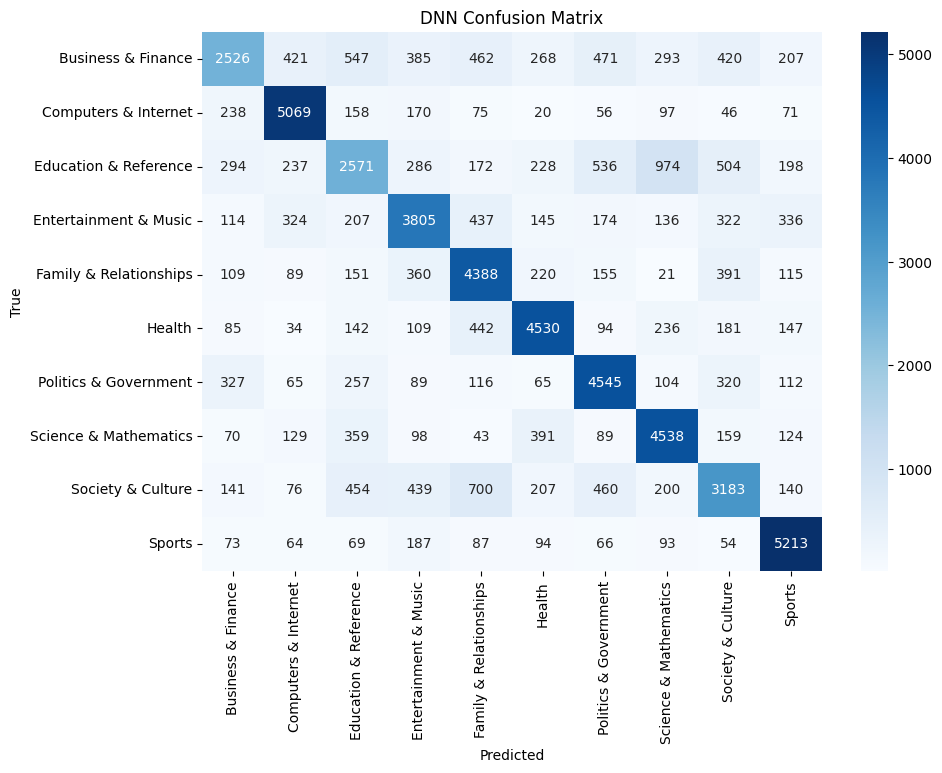

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict classes using DNN model
y_pred_dnn = dnn_model.predict(Xte)
y_pred_classes_dnn = np.argmax(y_pred_dnn, axis=1)

# Classification report
print(classification_report(y_test, y_pred_classes_dnn, target_names=le.classes_))

# Confusion matrix
cm_dnn = confusion_matrix(y_test, y_pred_classes_dnn)
plt.figure(figsize=(10,7))
sns.heatmap(cm_dnn, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('DNN Confusion Matrix')
plt.show()

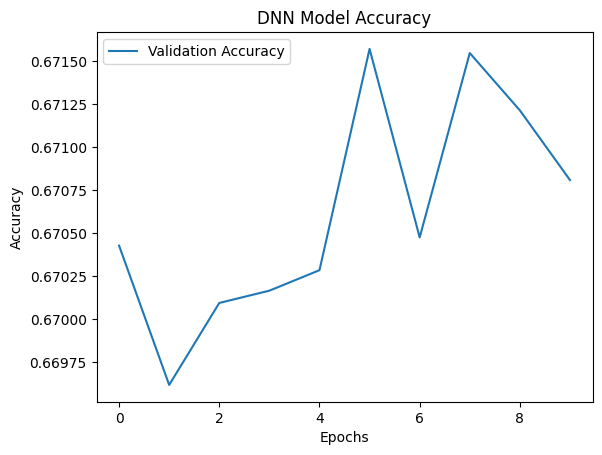

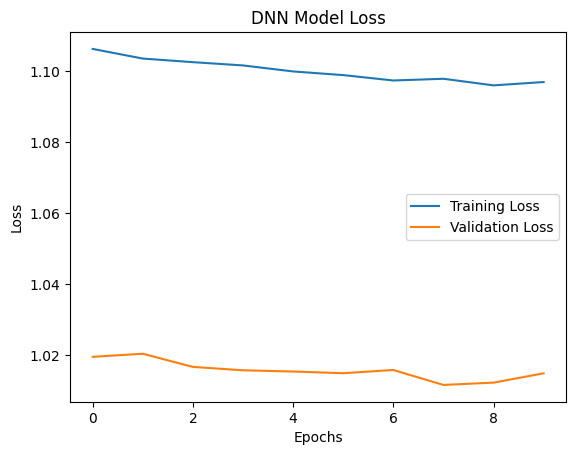

In [16]:
# Plot accuracy over epochs
plt.plot(dnn_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('DNN Model Accuracy')
plt.show()

# Plot loss over epochs
plt.plot(dnn_model_history.history['loss'], label='Training Loss')
plt.plot(dnn_model_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('DNN Model Loss')
plt.show()


# SimpleRNN + GloVe

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, Embedding, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

# Define the model
rnn_model = Sequential()

# Add the GloVe embedding layer
rnn_model.add(Embedding(input_dim=vocab_size,  # Size of the vocabulary
                    output_dim=embedding_dim,  # Use the embedding_dim variable (100)
                    weights=[embedding_matrix],  # Pre-trained GloVe embeddings
                    input_length=maxlen,  # Length of input sequences
                    trainable=False))     # Freeze the GloVe embeddings during training

# Add SimpleRNN layer
rnn_model.add(SimpleRNN(128, activation='tanh', return_sequences=True))  # SimpleRNN with 128 units

# Add GlobalAveragePooling1D to convert 3D output to 2D
# This averages the embeddings across the sequence dimension
rnn_model.add(GlobalAveragePooling1D())

# Add a Dense hidden layer with ReLU activation
rnn_model.add(Dense(128, activation='relu'))

# Add Dropout layer to prevent overfitting
rnn_model.add(Dropout(0.5))

# Add another Dense hidden layer
rnn_model.add(Dense(64, activation='relu'))

# Add another Dropout layer
rnn_model.add(Dropout(0.3))

# Output layer with softmax activation for multi-class classification
rnn_model.add(Dense(num_classes, activation='softmax'))

# Build the model explicitly to see proper output shapes
rnn_model.build(input_shape=(None, maxlen))

# Print the model summary
rnn_model.summary()

# Compile the model
rnn_model.compile(optimizer=Adam(learning_rate=0.002), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 140, 100)       │    10,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 140, 128)       │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,054,730 (38.36 MB)

 Trainable params: 54,730 (213.79 KB)

 Non-trainable params: 10,000,000 (38.15 MB)

In [22]:
# Train the rnn model
rnn_model_history = rnn_model.fit(Xtr, y_tr,
                            validation_data=(Xval, y_val),
                            epochs=10,
                            batch_size=64)


Epoch 1/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.5430 - loss: 1.4054 - val_accuracy: 0.5375 - val_loss: 1.4365
Epoch 2/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.4966 - loss: 1.5173 - val_accuracy: 0.5972 - val_loss: 1.2609
Epoch 3/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.5204 - loss: 1.4588 - val_accuracy: 0.5666 - val_loss: 1.3182
Epoch 4/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.5341 - loss: 1.4188 - val_accuracy: 0.6053 - val_loss: 1.2233
Epoch 5/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.5598 - loss: 1.3545 - val_accuracy: 0.5755 - val_loss: 1.3024
Epoch 6/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.5358 - loss: 1.4141 - val_accuracy: 0.5923 - val_loss: 1.2489
Epoch 7/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.5410 - loss: 1.4009 - val_accuracy: 0.5762 - val_loss: 1.2996
Epoch 8/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.4712 -

In [23]:
# Evaluate model on test set
test_loss, test_accuracy = rnn_model.evaluate(Xte, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5583 - loss: 1.3302
Test Loss: 1.238633632659912
Test Accuracy: 0.5945265889167786


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
                        precision    recall  f1-score   support

    Business & Finance       0.62      0.28      0.38      6000
  Computers & Internet       0.67      0.85      0.75      6000
 Education & Reference       0.60      0.17      0.27      6000
 Entertainment & Music       0.70      0.41      0.51      6000
Family & Relationships       0.53      0.65      0.59      5999
                Health       0.58      0.78      0.67      6000
 Politics & Government       0.53      0.79      0.63      6000
 Science & Mathematics       0.61      0.72      0.66      6000
     Society & Culture       0.43      0.53      0.48      6000
                Sports       0.80      0.76      0.78      6000

              accuracy                           0.59     59999
             macro avg       0.61      0.59      0.57     59999
          weighted avg       0.61      0.59      0.57     59999



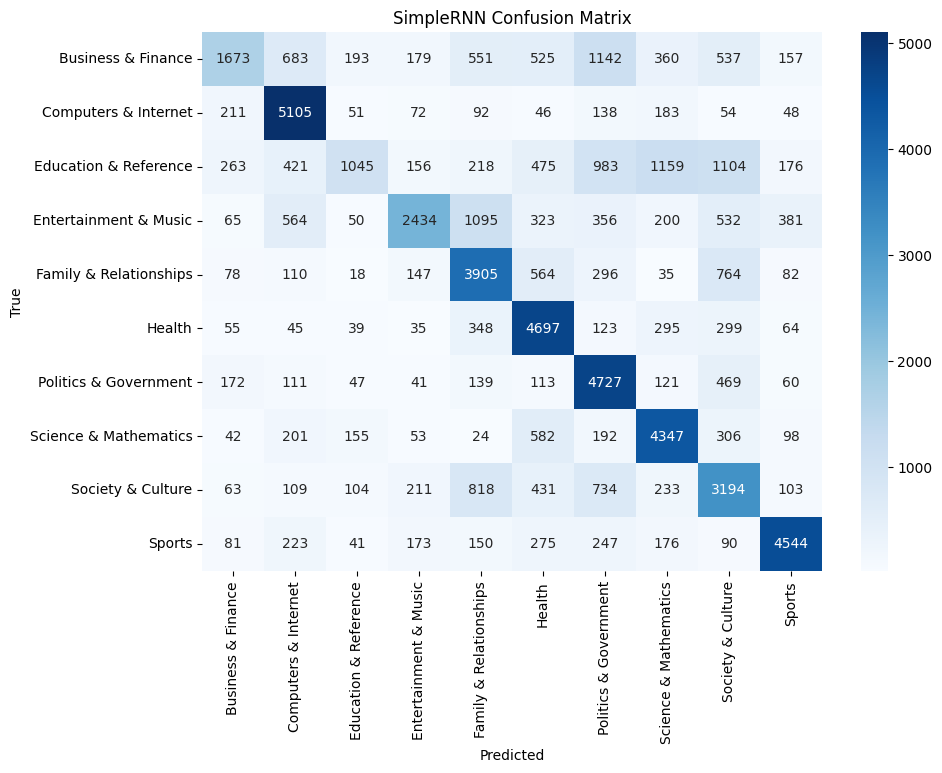

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict classes using SimpleRNN model
y_pred_rnn = rnn_model.predict(Xte)  # Replace rnn_model with your SimpleRNN model variable
y_pred_classes_rnn = np.argmax(y_pred_rnn, axis=1)  # Get predicted class indices

# Classification report
print(classification_report(y_test, y_pred_classes_rnn, target_names=le.classes_))

# Confusion matrix
cm_rnn = confusion_matrix(y_test, y_pred_classes_rnn)
plt.figure(figsize=(10,7))
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SimpleRNN Confusion Matrix')
plt.show()


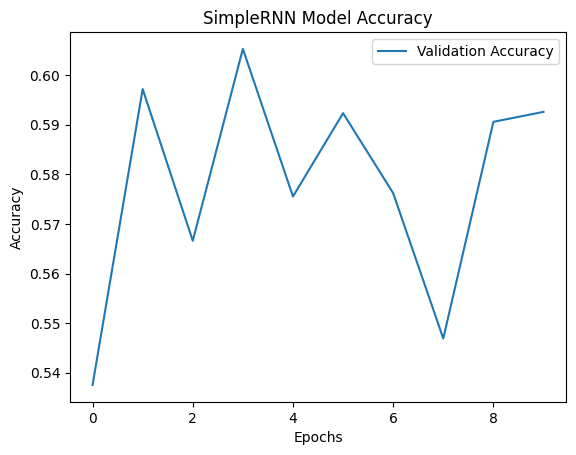

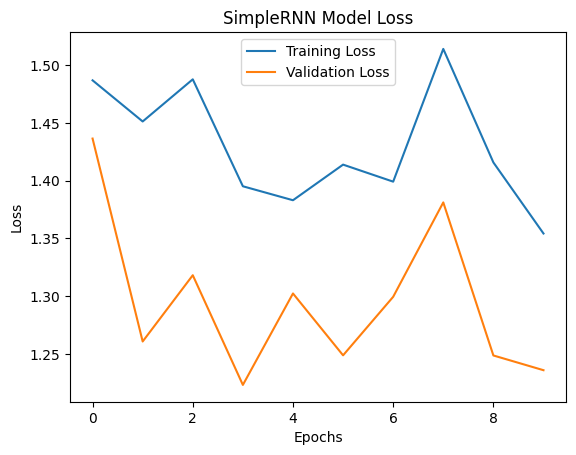

In [26]:
# Plot accuracy over epochs for SimpleRNN
plt.plot(rnn_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('SimpleRNN Model Accuracy')
plt.show()

# Plot loss over epochs for SimpleRNN
plt.plot(rnn_model_history.history['loss'], label='Training Loss')
plt.plot(rnn_model_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('SimpleRNN Model Loss')
plt.show()


# GRU + GloVe

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout

# Define the GRU model
gru_model = Sequential()

# Add GloVe embedding layer (Pre-trained embeddings)
gru_model.add(Embedding(input_dim=vocab_size,
                        output_dim=100,       # GloVe dimensionality
                        weights=[embedding_matrix],  # Pre-trained GloVe embeddings
                        input_length=maxlen,
                        trainable=False))  # Freeze the embeddings during training

# GRU layer
gru_model.add(GRU(128, activation='tanh'))  # GRU layer with 128 units and tanh activation

# Add Dropout for regularization
gru_model.add(Dropout(0.5))

# Dense hidden layer
gru_model.add(Dense(64, activation='relu'))

# Output layer
gru_model.add(Dense(num_classes, activation='softmax'))

gru_model.build(input_shape=(None, maxlen))

# Compile the model
gru_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
gru_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 140, 100)       │    10,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        88,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,097,226 (38.52 MB)

 Trainable params: 97,226 (379.79 KB)

 Non-trainable params: 10,000,000 (38.15 MB)

In [28]:
# Train the GRU model
gru_history = gru_model.fit(Xtr, y_tr,
                            validation_data=(Xval, y_val),
                            epochs=10,
                            batch_size=256)


Epoch 1/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.1580 - loss: 2.1940 - val_accuracy: 0.3968 - val_loss: 1.6713
Epoch 2/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.4787 - loss: 1.4969 - val_accuracy: 0.6300 - val_loss: 1.1417
Epoch 3/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.6381 - loss: 1.1395 - val_accuracy: 0.6681 - val_loss: 1.0364
Epoch 4/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.6713 - loss: 1.0495 - val_accuracy: 0.6834 - val_loss: 0.9875
Epoch 5/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.6836 - loss: 1.0061 - val_accuracy: 0.6913 - val_loss: 0.9540
Epoch 6/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.6922 - loss: 0.9746 - val_accuracy: 0.6943 - val_loss: 0.9457
Epoch 7/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.6968 - loss: 0.9561 - val_accuracy: 0.7026 - val_loss: 0.9217
Epoch 8/10
930/930 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.7048 - loss: 0.9328 - 

In [29]:
# Evaluate model on test set
test_loss, test_accuracy = gru_model.evaluate(Xte, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6668 - loss: 1.0191
Test Loss: 0.9115950465202332
Test Accuracy: 0.7082451581954956


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
                        precision    recall  f1-score   support

    Business & Finance       0.64      0.47      0.54      6000
  Computers & Internet       0.84      0.85      0.84      6000
 Education & Reference       0.64      0.43      0.51      6000
 Entertainment & Music       0.68      0.71      0.69      6000
Family & Relationships       0.62      0.82      0.71      5999
                Health       0.72      0.81      0.76      6000
 Politics & Government       0.75      0.78      0.76      6000
 Science & Mathematics       0.74      0.74      0.74      6000
     Society & Culture       0.59      0.59      0.59      6000
                Sports       0.85      0.88      0.87      6000

              accuracy                           0.71     59999
             macro avg       0.71      0.71      0.70     59999
          weighted avg       0.71      0.71      0.70     59999



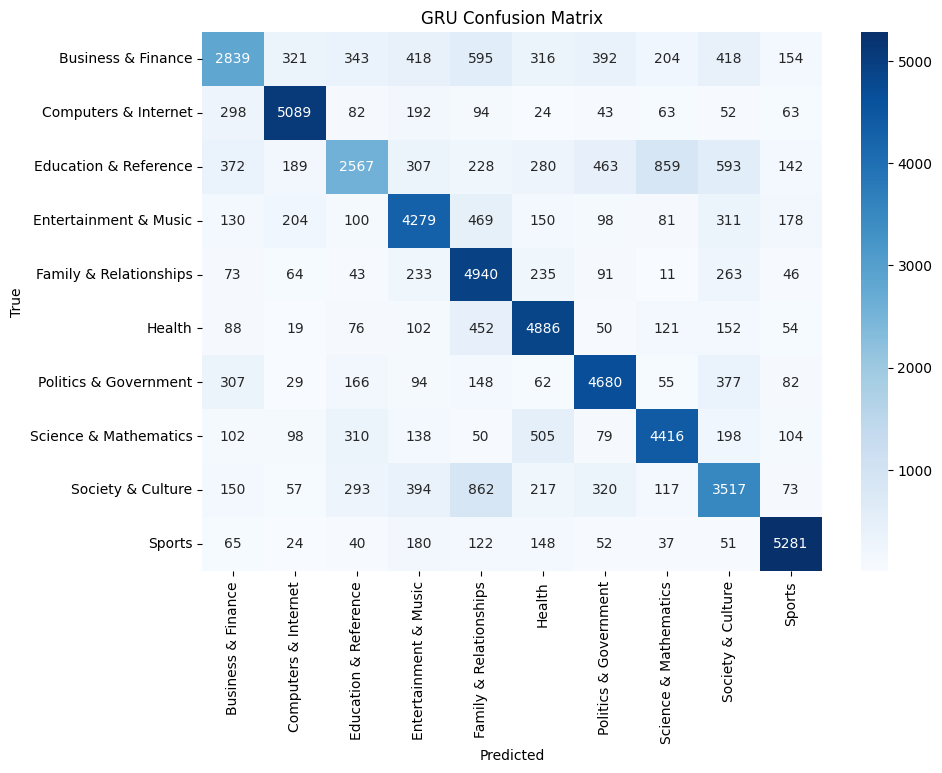

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict classes using GRU model
y_pred_gru = gru_model.predict(Xte)
y_pred_classes_gru = np.argmax(y_pred_gru, axis=1)

# Classification report
print(classification_report(y_test, y_pred_classes_gru, target_names=le.classes_))

# Confusion matrix
cm_gru = confusion_matrix(y_test, y_pred_classes_gru)
plt.figure(figsize=(10,7))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('GRU Confusion Matrix')
plt.show()


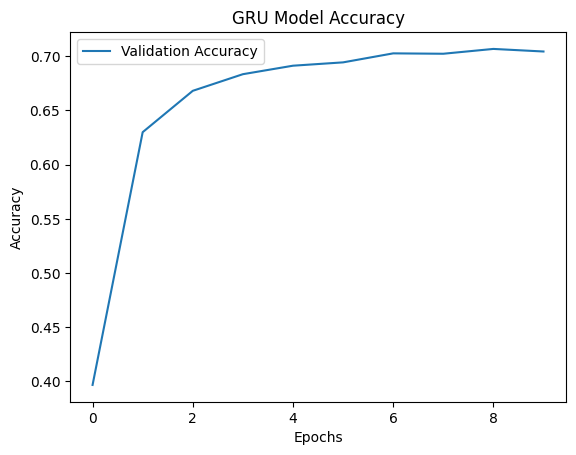

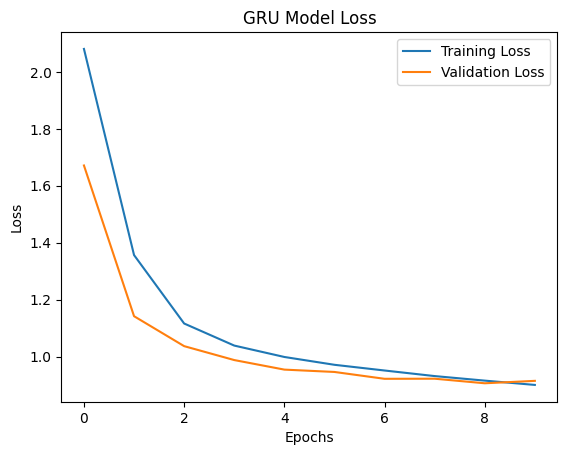

In [31]:
plt.plot(gru_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('GRU Model Accuracy')
plt.show()

# Plot loss over epochs
plt.plot(gru_history.history['loss'], label='Training Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('GRU Model Loss')
plt.show()

# **LSTM** + Glove

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define the LSTM model
lstm_model = Sequential()

# Add GloVe embedding layer (Pre-trained embeddings)
lstm_model.add(Embedding(input_dim=vocab_size,
                         output_dim=100,       # GloVe dimensionality
                         weights=[embedding_matrix],  # Pre-trained GloVe embeddings
                         input_length=maxlen,
                         trainable=False))  # Freeze the embeddings during training

# Add LSTM layer
lstm_model.add(LSTM(128, activation='tanh'))  # LSTM layer with 128 units and tanh activation

# Add Dropout for regularization
lstm_model.add(Dropout(0.5))

# Dense hidden layer
lstm_model.add(Dense(64, activation='relu'))

# Output layer
lstm_model.add(Dense(num_classes, activation='softmax'))

lstm_model.build(input_shape=(None, maxlen))

# Compile the model
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
lstm_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 140, 100)       │    10,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,126,154 (38.63 MB)

 Trainable params: 126,154 (492.79 KB)

 Non-trainable params: 10,000,000 (38.15 MB)

In [36]:
# Train the LSTM model
lstm_history = lstm_model.fit(Xtr, y_tr,
                              validation_data=(Xval, y_val),
                              epochs=10,
                              batch_size=64)


Epoch 1/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - accuracy: 0.1415 - loss: 2.2424 - val_accuracy: 0.3800 - val_loss: 1.7779
Epoch 2/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - accuracy: 0.5611 - loss: 1.3463 - val_accuracy: 0.6798 - val_loss: 1.0039
Epoch 3/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - accuracy: 0.6816 - loss: 1.0201 - val_accuracy: 0.6958 - val_loss: 0.9520
Epoch 4/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - accuracy: 0.6977 - loss: 0.9619 - val_accuracy: 0.7005 - val_loss: 0.9298
Epoch 5/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - accuracy: 0.7088 - loss: 0.9208 - val_accuracy: 0.7035 - val_loss: 0.9154
Epoch 6/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - accuracy: 0.7170 - loss: 0.8944 - val_accuracy: 0.7096 - val_loss: 0.9041
Epoch 7/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - accuracy: 0.7238 - loss: 0.8730 - val_accuracy: 0.7091 - val_loss: 0.9001
Epoch 8/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - accuracy: 0.7328 - loss: 0

In [37]:
# Evaluate model on test set
test_loss, test_accuracy = lstm_model.evaluate(Xte, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6705 - loss: 1.0119
Test Loss: 0.9137930274009705
Test Accuracy: 0.7100618481636047


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
                        precision    recall  f1-score   support

    Business & Finance       0.62      0.49      0.55      6000
  Computers & Internet       0.80      0.88      0.84      6000
 Education & Reference       0.63      0.43      0.51      6000
 Entertainment & Music       0.70      0.70      0.70      6000
Family & Relationships       0.72      0.75      0.73      5999
                Health       0.76      0.77      0.76      6000
 Politics & Government       0.73      0.80      0.76      6000
 Science & Mathematics       0.65      0.82      0.72      6000
     Society & Culture       0.58      0.60      0.59      6000
                Sports       0.87      0.87      0.87      6000

              accuracy                           0.71     59999
             macro avg       0.71      0.71      0.70     59999
          weighted avg       0.71      0.71      0.70     59999



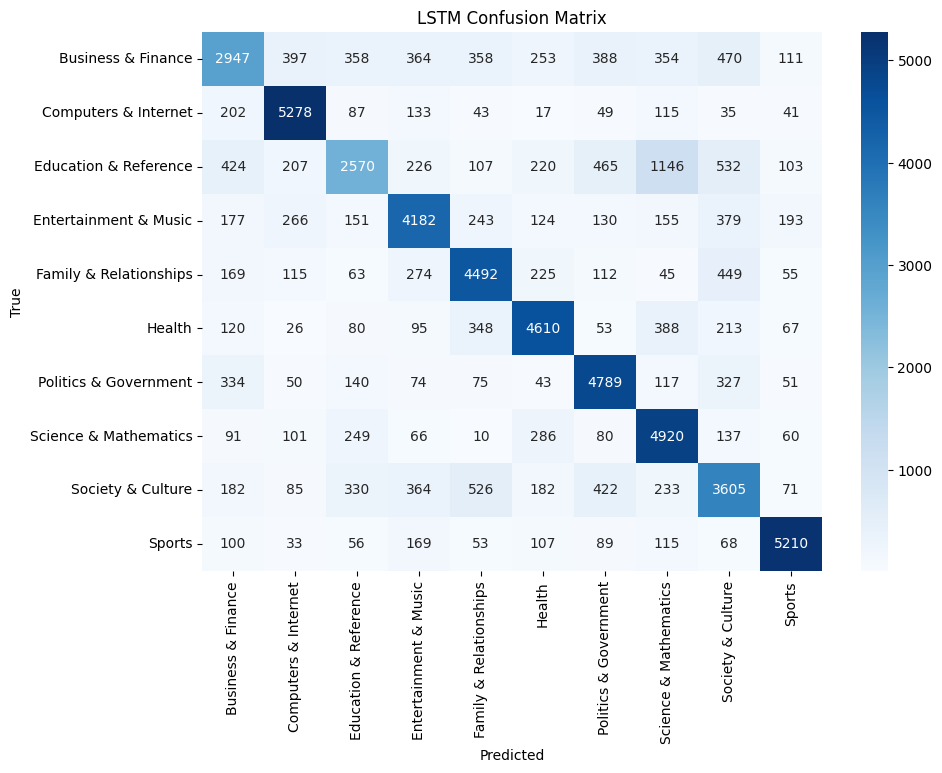

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict classes using LSTM model
y_pred_lstm = lstm_model.predict(Xte)
y_pred_classes_lstm = np.argmax(y_pred_lstm, axis=1)

# Classification report
print(classification_report(y_test, y_pred_classes_lstm, target_names=le.classes_))

# Confusion matrix
cm_lstm = confusion_matrix(y_test, y_pred_classes_lstm)
plt.figure(figsize=(10,7))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('LSTM Confusion Matrix')
plt.show()


# Bidirectional Simple RNN + GloVe

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Bidirectional, Dense, Dropout

# Define the Bidirectional SimpleRNN model
bi_rnn_model = Sequential()

# Add GloVe embedding layer (Pre-trained embeddings)
bi_rnn_model.add(Embedding(input_dim=vocab_size,
                           output_dim=100,       # GloVe dimensionality
                           weights=[embedding_matrix],  # Pre-trained GloVe embeddings
                           input_length=maxlen,
                           trainable=False))  # Freeze the embeddings during training

# Add Bidirectional SimpleRNN layer
bi_rnn_model.add(Bidirectional(SimpleRNN(128, activation='tanh')))  # 128 units

# Add Dropout for regularization
bi_rnn_model.add(Dropout(0.5))

# Dense hidden layer
bi_rnn_model.add(Dense(64, activation='relu'))

# Output layer
bi_rnn_model.add(Dense(num_classes, activation='softmax'))

bi_rnn_model.build(input_shape=(None, maxlen))

# Compile the model
bi_rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
bi_rnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 140, 100)       │    10,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │        58,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,075,722 (38.44 MB)

 Trainable params: 75,722 (295.79 KB)

 Non-trainable params: 10,000,000 (38.15 MB)

In [42]:
# Train the Bidirectional SimpleRNN model
bi_rnn_history = bi_rnn_model.fit(Xtr, y_tr,
                                  validation_data=(Xval, y_val),
                                  epochs=10,
                                  batch_size=128)


Epoch 1/10
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 47s 25ms/step - accuracy: 0.5664 - loss: 1.3644 - val_accuracy: 0.6353 - val_loss: 1.1554
Epoch 2/10
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 43s 23ms/step - accuracy: 0.5786 - loss: 1.3394 - val_accuracy: 0.6296 - val_loss: 1.1678
Epoch 3/10
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 43s 23ms/step - accuracy: 0.6208 - loss: 1.2164 - val_accuracy: 0.5686 - val_loss: 1.3354
Epoch 4/10
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 43s 23ms/step - accuracy: 0.5889 - loss: 1.2950 - val_accuracy: 0.6128 - val_loss: 1.2202
Epoch 5/10
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 43s 23ms/step - accuracy: 0.5970 - loss: 1.2750 - val_accuracy: 0.6488 - val_loss: 1.1117
Epoch 6/10
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 43s 23ms/step - accuracy: 0.6251 - loss: 1.2017 - val_accuracy: 0.6484 - val_loss: 1.1191
Epoch 7/10
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 43s 23ms/step - accuracy: 0.6417 - loss: 1.1571 - val_accuracy: 0.6188 - val_loss: 1.2066
Epoch 8/10
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 43s 23ms/step - accuracy: 0.6211 -

In [43]:
# Evaluate the model on test set
test_loss, test_accuracy = bi_rnn_model.evaluate(Xte, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.6113 - loss: 1.2191
Test Loss: 1.1427079439163208
Test Accuracy: 0.6412773728370667


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step
                        precision    recall  f1-score   support

    Business & Finance       0.49      0.48      0.48      6000
  Computers & Internet       0.74      0.84      0.79      6000
 Education & Reference       0.53      0.36      0.43      6000
 Entertainment & Music       0.66      0.58      0.62      6000
Family & Relationships       0.60      0.71      0.65      5999
                Health       0.63      0.78      0.70      6000
 Politics & Government       0.60      0.77      0.68      6000
 Science & Mathematics       0.64      0.71      0.68      6000
     Society & Culture       0.68      0.39      0.49      6000
                Sports       0.84      0.78      0.81      6000

              accuracy                           0.64     59999
             macro avg       0.64      0.64      0.63     59999
          weighted avg       0.64      0.64      0.63     59999



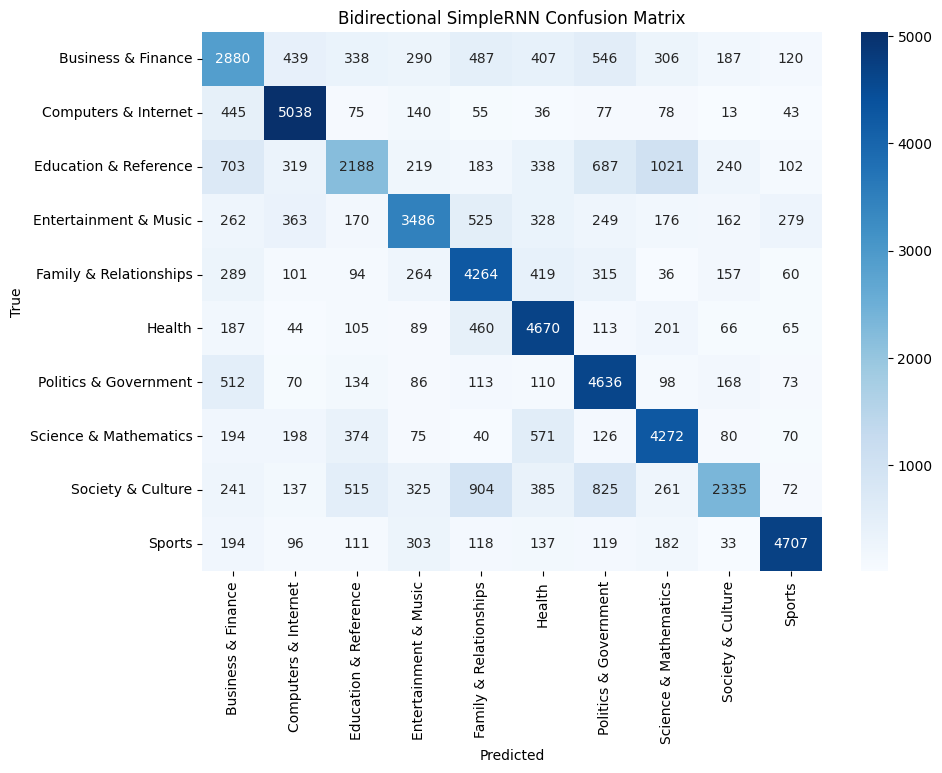

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict classes using Bidirectional SimpleRNN model
y_pred_bi_rnn = bi_rnn_model.predict(Xte)
y_pred_classes_bi_rnn = np.argmax(y_pred_bi_rnn, axis=1)

# Classification report
print(classification_report(y_test, y_pred_classes_bi_rnn, target_names=le.classes_))

# Confusion matrix
cm_bi_rnn = confusion_matrix(y_test, y_pred_classes_bi_rnn)
plt.figure(figsize=(10,7))
sns.heatmap(cm_bi_rnn, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Bidirectional SimpleRNN Confusion Matrix')
plt.show()


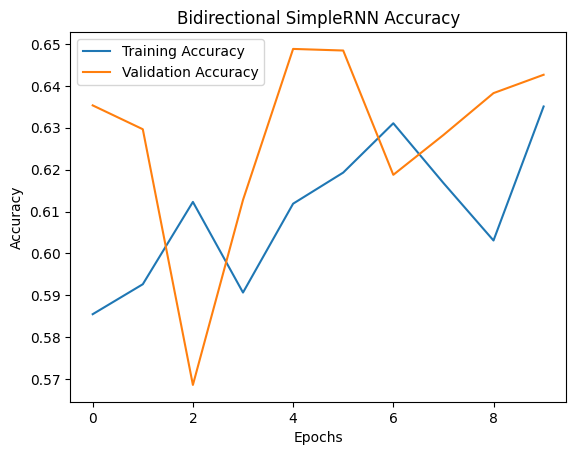

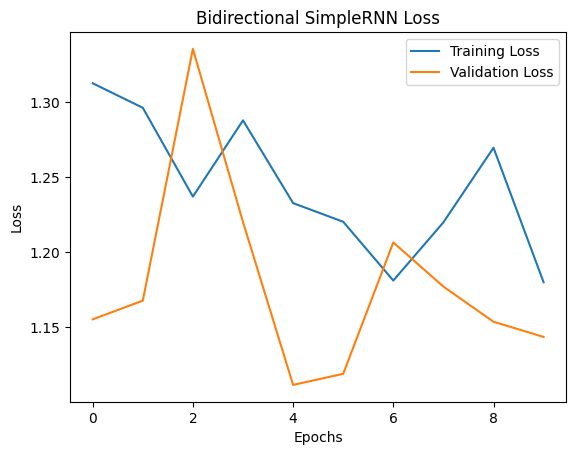

In [45]:
# Plot accuracy over epochs
plt.plot(bi_rnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(bi_rnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Bidirectional SimpleRNN Accuracy')
plt.show()

# Plot loss over epochs
plt.plot(bi_rnn_history.history['loss'], label='Training Loss')
plt.plot(bi_rnn_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Bidirectional SimpleRNN Loss')
plt.show()


# Bidirectional GRU + GloVe

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Bidirectional, Dense, Dropout

# Define the Bidirectional GRU model
bi_gru_model = Sequential()

# Add GloVe embedding layer (Pre-trained embeddings)
bi_gru_model.add(Embedding(input_dim=vocab_size,
                           output_dim=100,       # GloVe dimensionality
                           weights=[embedding_matrix],  # Pre-trained GloVe embeddings
                           input_length=maxlen,
                           trainable=False))  # Freeze the embeddings during training

# Add Bidirectional GRU layer
bi_gru_model.add(Bidirectional(GRU(128, activation='tanh')))  # 128 units, tanh activation

# Add Dropout for regularization
bi_gru_model.add(Dropout(0.5))

# Dense hidden layer
bi_gru_model.add(Dense(64, activation='relu'))

# Output layer
bi_gru_model.add(Dense(num_classes, activation='softmax'))

bi_gru_model.build(input_shape=(None, maxlen))

# Compile the model
bi_gru_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
bi_gru_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 140, 100)       │    10,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       176,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,193,738 (38.89 MB)

 Trainable params: 193,738 (756.79 KB)

 Non-trainable params: 10,000,000 (38.15 MB)

In [47]:
# Train the Bidirectional GRU model
bi_gru_history = bi_gru_model.fit(Xtr, y_tr,
                                  validation_data=(Xval, y_val),
                                  epochs=10,
                                  batch_size=64)


Epoch 1/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 59s 15ms/step - accuracy: 0.6147 - loss: 1.1834 - val_accuracy: 0.6935 - val_loss: 0.9448
Epoch 2/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.6914 - loss: 0.9626 - val_accuracy: 0.7030 - val_loss: 0.9132
Epoch 3/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.7028 - loss: 0.9239 - val_accuracy: 0.7077 - val_loss: 0.8933
Epoch 4/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.7120 - loss: 0.8991 - val_accuracy: 0.7089 - val_loss: 0.8893
Epoch 5/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.7151 - loss: 0.8863 - val_accuracy: 0.7119 - val_loss: 0.8861
Epoch 6/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.7209 - loss: 0.8678 - val_accuracy: 0.7121 - val_loss: 0.8865
Epoch 7/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.7265 - loss: 0.8506 - val_accuracy: 0.7131 - val_loss: 0.8865
Epoch 8/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.7293 -

In [48]:
# Evaluate the model on test set
test_loss, test_accuracy = bi_gru_model.evaluate(Xte, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6719 - loss: 0.9978
Test Loss: 0.8957644701004028
Test Accuracy: 0.7121618986129761


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step
                        precision    recall  f1-score   support

    Business & Finance       0.64      0.47      0.54      6000
  Computers & Internet       0.79      0.89      0.84      6000
 Education & Reference       0.57      0.49      0.53      6000
 Entertainment & Music       0.72      0.68      0.70      6000
Family & Relationships       0.67      0.80      0.73      5999
                Health       0.76      0.79      0.77      6000
 Politics & Government       0.71      0.80      0.75      6000
 Science & Mathematics       0.71      0.77      0.74      6000
     Society & Culture       0.63      0.55      0.59      6000
                Sports       0.87      0.88      0.88      6000

              accuracy                           0.71     59999
             macro avg       0.71      0.71      0.71     59999
          weighted avg       0.71      0.71      0.71     59999



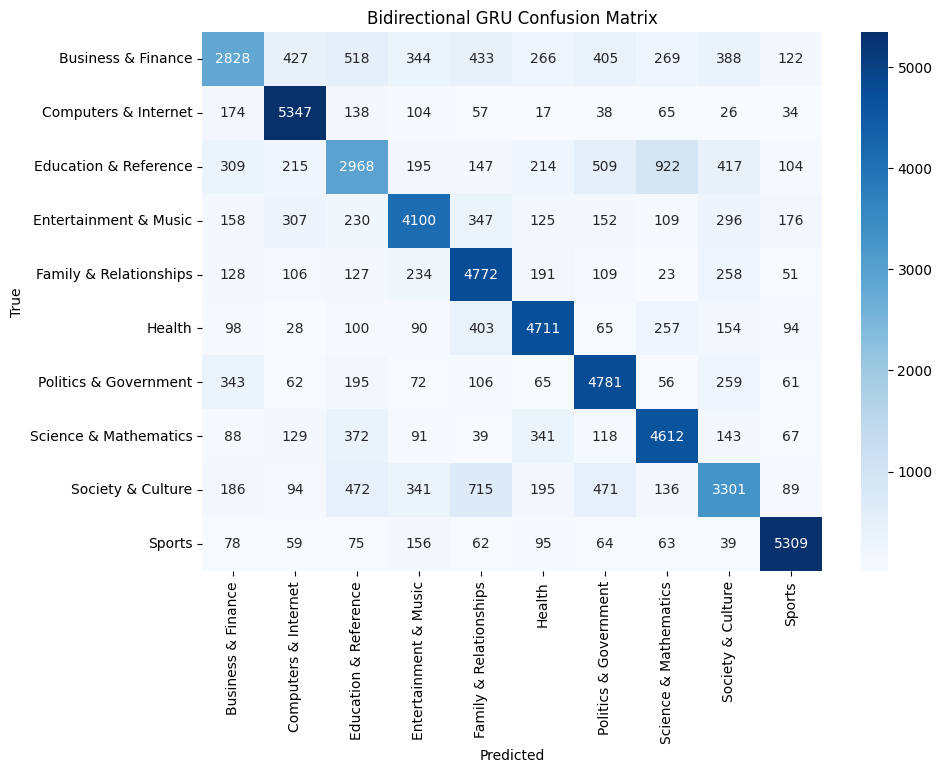

In [49]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict classes using Bidirectional GRU model
y_pred_bi_gru = bi_gru_model.predict(Xte)
y_pred_classes_bi_gru = np.argmax(y_pred_bi_gru, axis=1)

# Classification report
print(classification_report(y_test, y_pred_classes_bi_gru, target_names=le.classes_))

# Confusion matrix
cm_bi_gru = confusion_matrix(y_test, y_pred_classes_bi_gru)
plt.figure(figsize=(10,7))
sns.heatmap(cm_bi_gru, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Bidirectional GRU Confusion Matrix')
plt.show()


# Bidirectional LSTM + GloVe

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout

# Define the Bidirectional LSTM model
bi_lstm_model = Sequential()

# Add GloVe embedding layer (Pre-trained embeddings)
bi_lstm_model.add(Embedding(input_dim=vocab_size,
                            output_dim=100,       # GloVe dimensionality
                            weights=[embedding_matrix],  # Pre-trained GloVe embeddings
                            input_length=maxlen,
                            trainable=False))  # Freeze the embeddings during training

# Add Bidirectional LSTM layer
bi_lstm_model.add(Bidirectional(LSTM(128, activation='tanh')))  # 128 units, tanh activation

# Add Dropout for regularization
bi_lstm_model.add(Dropout(0.5))

# Dense hidden layer
bi_lstm_model.add(Dense(64, activation='relu'))

# Output layer
bi_lstm_model.add(Dense(num_classes, activation='softmax'))

bi_lstm_model.build(input_shape=(None, maxlen))

# Compile the model
bi_lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
bi_lstm_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 140, 100)       │    10,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,251,594 (39.11 MB)

 Trainable params: 251,594 (982.79 KB)

 Non-trainable params: 10,000,000 (38.15 MB)

In [51]:
# Train the Bidirectional LSTM model
bi_lstm_history = bi_lstm_model.fit(Xtr, y_tr,
                                    validation_data=(Xval, y_val),
                                    epochs=10,
                                    batch_size=64)

Epoch 1/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 65s 16ms/step - accuracy: 0.6194 - loss: 1.1847 - val_accuracy: 0.6938 - val_loss: 0.9420
Epoch 2/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 60s 16ms/step - accuracy: 0.6942 - loss: 0.9601 - val_accuracy: 0.7039 - val_loss: 0.9088
Epoch 3/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 61s 16ms/step - accuracy: 0.7054 - loss: 0.9212 - val_accuracy: 0.7093 - val_loss: 0.8957
Epoch 4/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 60s 16ms/step - accuracy: 0.7136 - loss: 0.8981 - val_accuracy: 0.7118 - val_loss: 0.8861
Epoch 5/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 60s 16ms/step - accuracy: 0.7197 - loss: 0.8761 - val_accuracy: 0.7151 - val_loss: 0.8836
Epoch 6/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 60s 16ms/step - accuracy: 0.7252 - loss: 0.8556 - val_accuracy: 0.7105 - val_loss: 0.8845
Epoch 7/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 60s 16ms/step - accuracy: 0.7278 - loss: 0.8434 - val_accuracy: 0.7155 - val_loss: 0.8784
Epoch 8/10
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 60s 16ms/step - accuracy: 0.7319 -

In [52]:
# Evaluate the model on test set
test_loss, test_accuracy = bi_lstm_model.evaluate(Xte, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6744 - loss: 0.9940
Test Loss: 0.8904904723167419
Test Accuracy: 0.7148119211196899


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step
                        precision    recall  f1-score   support

    Business & Finance       0.64      0.48      0.55      6000
  Computers & Internet       0.81      0.87      0.84      6000
 Education & Reference       0.62      0.46      0.53      6000
 Entertainment & Music       0.66      0.73      0.70      6000
Family & Relationships       0.70      0.76      0.73      5999
                Health       0.73      0.82      0.77      6000
 Politics & Government       0.76      0.77      0.77      6000
 Science & Mathematics       0.70      0.78      0.74      6000
     Society & Culture       0.60      0.59      0.60      6000
                Sports       0.87      0.88      0.88      6000

              accuracy                           0.71     59999
             macro avg       0.71      0.71      0.71     59999
          weighted avg       0.71      0.71      0.71     59999



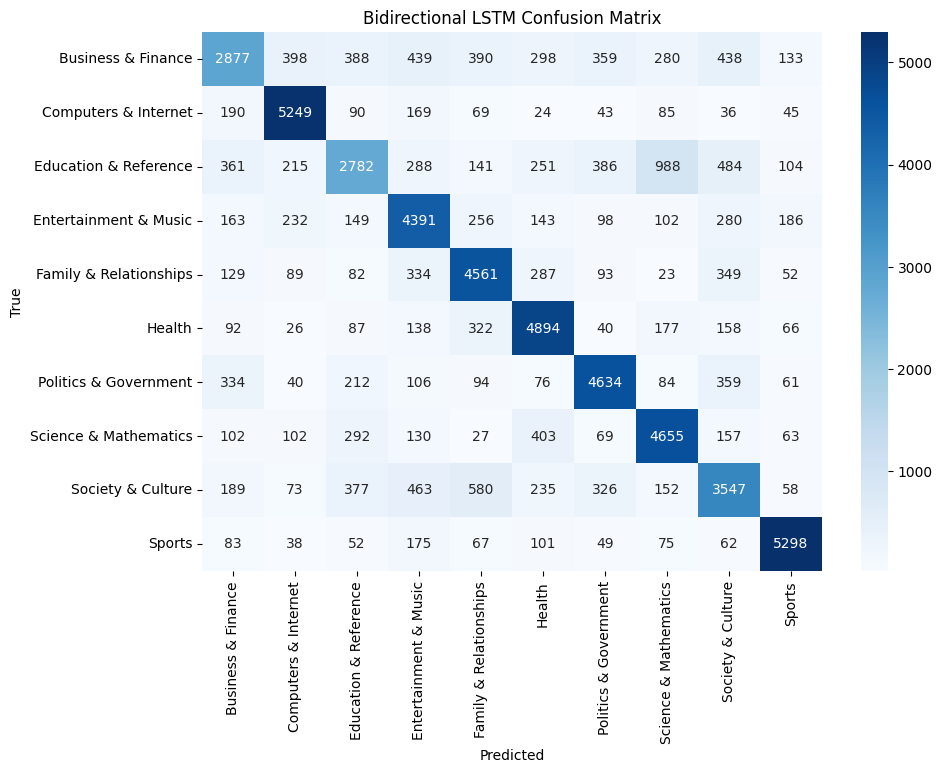

In [53]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict classes using Bidirectional LSTM model
y_pred_bi_lstm = bi_lstm_model.predict(Xte)
y_pred_classes_bi_lstm = np.argmax(y_pred_bi_lstm, axis=1)

# Classification report
print(classification_report(y_test, y_pred_classes_bi_lstm, target_names=le.classes_))

# Confusion matrix
cm_bi_lstm = confusion_matrix(y_test, y_pred_classes_bi_lstm)
plt.figure(figsize=(10,7))
sns.heatmap(cm_bi_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Bidirectional LSTM Confusion Matrix')
plt.show()


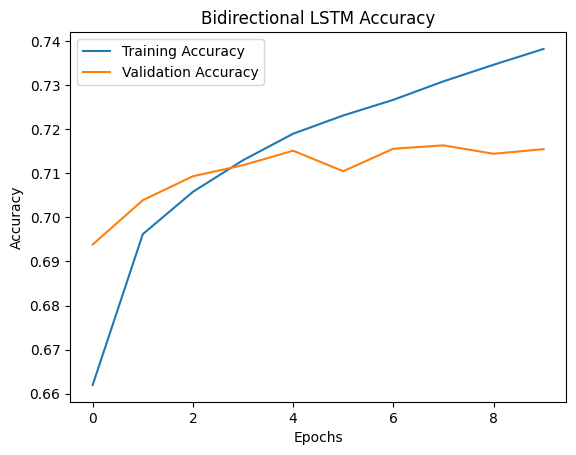

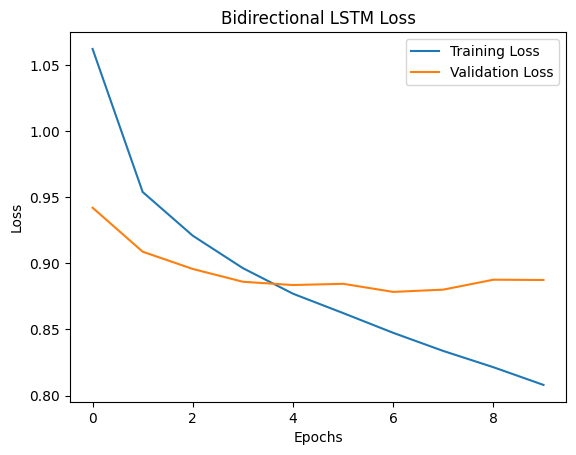

In [54]:
# Plot accuracy over epochs
plt.plot(bi_lstm_history.history['accuracy'], label='Training Accuracy')
plt.plot(bi_lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Bidirectional LSTM Accuracy')
plt.show()

# Plot loss over epochs
plt.plot(bi_lstm_history.history['loss'], label='Training Loss')
plt.plot(bi_lstm_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Bidirectional LSTM Loss')
plt.show()


# Final Train And Validation Accuracy After 10 Epochs

In [70]:
import pandas as pd

results = {
    "Model": ["DNN", "SimpleRNN", "GRU", "LSTM", "Bidirectional SimpleRNN", "Bidirectional GRU", "Bidirectional LSTM"],
    "Final Training Accuracy": [0.6532, 0.5569, 0.7138, 0.7420, 0.6317, 0.7396, 0.7383],
    "Final Validation Accuracy": [0.6708, 0.5926, 0.7044, 0.7085, 0.6426, 0.7127, 0.7155],
    "Epochs" : [10, 10, 10, 10, 10, 10, 10]
}

results_df = pd.DataFrame(results)
print(results_df)

                     Model  Final Training Accuracy  \
0                      DNN                   0.6532   
1                SimpleRNN                   0.5569   
2                      GRU                   0.7138   
3                     LSTM                   0.7420   
4  Bidirectional SimpleRNN                   0.6317   
5        Bidirectional GRU                   0.7396   
6       Bidirectional LSTM                   0.7383   

   Final Validation Accuracy  Epochs  
0                     0.6708      10  
1                     0.5926      10  
2                     0.7044      10  
3                     0.7085      10  
4                     0.6426      10  
5                     0.7127      10  
6                     0.7155      10  


# Macro Precision, Recall and F1-score Metrics for all the models 

In [71]:
from sklearn.metrics import classification_report
import pandas as pd

def get_macro_metrics(y_true, y_pred_classes, target_names):
    report = classification_report(y_true, y_pred_classes, target_names=target_names, output_dict=True)
    macro_avg = report['macro avg']
    return macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score']

# Get macro metrics for each model
precision_dnn, recall_dnn, f1_dnn = get_macro_metrics(y_test, y_pred_classes_dnn, le.classes_)
precision_rnn, recall_rnn, f1_rnn = get_macro_metrics(y_test, y_pred_classes_rnn, le.classes_)
precision_gru, recall_gru, f1_gru = get_macro_metrics(y_test, y_pred_classes_gru, le.classes_)
precision_lstm, recall_lstm, f1_lstm = get_macro_metrics(y_test, y_pred_classes_lstm, le.classes_)
precision_bi_rnn, recall_bi_rnn, f1_bi_rnn = get_macro_metrics(y_test, y_pred_classes_bi_rnn, le.classes_)
precision_bi_gru, recall_bi_gru, f1_bi_gru = get_macro_metrics(y_test, y_pred_classes_bi_gru, le.classes_)
precision_bi_lstm, recall_bi_lstm, f1_bi_lstm = get_macro_metrics(y_test, y_pred_classes_bi_lstm, le.classes_)


results_macro = {
    "Model": ["DNN", "SimpleRNN", "GRU", "LSTM", "Bidirectional SimpleRNN", "Bidirectional GRU", "Bidirectional LSTM"],
    "Macro Precision": [precision_dnn, precision_rnn, precision_gru, precision_lstm, precision_bi_rnn, precision_bi_gru, precision_bi_lstm],
    "Macro Recall": [recall_dnn, recall_rnn, recall_gru, recall_lstm, recall_bi_rnn, recall_bi_gru, recall_bi_lstm],
    "Macro F1-score": [f1_dnn, f1_rnn, f1_gru, f1_lstm, f1_bi_rnn, f1_bi_gru, f1_bi_lstm]
}

results_macro_df = pd.DataFrame(results_macro)
results_macro_df = results_macro_df.sort_values(by="Macro F1-score", ascending=False).reset_index(drop=True)
print(results_macro_df)

                     Model  Macro Precision  Macro Recall  Macro F1-score
0       Bidirectional LSTM         0.709834      0.714813        0.709287
1        Bidirectional GRU         0.706701      0.712163        0.706337
2                     LSTM         0.706670      0.710062        0.704316
3                      GRU         0.706224      0.708247        0.702025
4                      DNN         0.666216      0.672812        0.665674
5  Bidirectional SimpleRNN         0.641642      0.641279        0.632795
6                SimpleRNN         0.607512      0.594528        0.572458


# Test Accuracy of All the Models ( Sorted Highest to Lowest )

In [72]:
import pandas as pd

results = {
    "Model": ["DNN", "SimpleRNN", "GRU", "LSTM", "Bidirectional SimpleRNN", "Bidirectional GRU", "Bidirectional LSTM"],
   
    "Test Accuracy": [dnn_model.evaluate(Xte, y_test, verbose=0)[1],
                      rnn_model.evaluate(Xte, y_test, verbose=0)[1],
                      gru_model.evaluate(Xte, y_test, verbose=0)[1],
                      lstm_model.evaluate(Xte, y_test, verbose=0)[1],
                      bi_rnn_model.evaluate(Xte, y_test, verbose=0)[1],
                      bi_gru_model.evaluate(Xte, y_test, verbose=0)[1],
                      bi_lstm_model.evaluate(Xte, y_test, verbose=0)[1]],
    "Test Loss": [dnn_model.evaluate(Xte, y_test, verbose=0)[0],
                  rnn_model.evaluate(Xte, y_test, verbose=0)[0],
                  gru_model.evaluate(Xte, y_test, verbose=0)[0],
                  lstm_model.evaluate(Xte, y_test, verbose=0)[0],
                  bi_rnn_model.evaluate(Xte, y_test, verbose=0)[0],
                  bi_gru_model.evaluate(Xte, y_test, verbose=0)[0],
                  bi_lstm_model.evaluate(Xte, y_test, verbose=0)[0]]
}

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Test Accuracy", ascending=False).reset_index(drop=True)
print(results_df)

                     Model  Test Accuracy  Test Loss
0       Bidirectional LSTM       0.714812   0.890490
1        Bidirectional GRU       0.712162   0.895764
2                     LSTM       0.710062   0.913793
3                      GRU       0.708245   0.911595
4                      DNN       0.672811   1.011775
5  Bidirectional SimpleRNN       0.641277   1.142708
6                SimpleRNN       0.594527   1.238634



# ------------------------------ CONCLUSION --------------------------------------------------
# Best Performing NN Model --------- ** Bidirectional LSTM + GloVe** w/ 71.48% Test Accuracy**
# Worst Performing NN Model --------- SimpleRNN + GloVe with 59.5% Test Accuracy
# --------------------------------------------------------------------------------------------